# Analyzing 1D Densities in the Core

In [1]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from scipy.signal import argrelextrema

import dgutils
from dgutils import colors as colortools
from numpy import pi as π
from wetting_utils import *
from collections import defaultdict
import matplotlib.transforms as mtransforms
from heprops import helium,potential
from pimcscripts import pimchelp


%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Load Radial Density Data from Disk

In [19]:
L = 25 # Å
element = ['Ar','Cs']
R = np.array([6.0,8.0])

ϱ = {}
est = {}
μval = {}
μ_sorted = {}
μmin_max = {}
N = {}
sort_idx = {}

for el in element:
    for cR in R:
        ϱ[lab(el,cR)] = pimchelp.PIMCResults(f'../data/pimc/{el}R{int(cR)}/radial-u-reduce.dat')
        est[lab(el,cR)] = pimchelp.PIMCResults(f'../data/pimc/{el}R{int(cR)}/estimator-u-reduce.dat')
        
        # we get a vector of μ values from the params and sort (as it is currently out of order)
        μval[lab(el,cR)] = np.array([float(par.split("=", 1)[-1]) for par in ϱ[lab(el,cR)].params])
        sort_idx[lab(el,cR)] = np.argsort(μval[lab(el,cR)])
        μ_sorted[lab(el,cR)] = np.copy(μval[lab(el,cR)])[sort_idx[lab(el,cR)]]

        μmin_max[el,cR] = (μval[lab(el,cR)].min(),μval[lab(el,cR)].max())

        # get the # particles for each element and radius and chemical potential
        N[lab(el,cR)] = np.array([normalize_psi_PIMC(ϱ[lab(el,cR)].y(par),ϱ[lab(el,cR)].x(par)) for par in ϱ[lab(el,cR)].params])
        N[lab(el,cR)] = N[lab(el,cR)][sort_idx[lab(el,cR)]]

## Determine the location of the first minimum for the maximal chemical potential

In [7]:
Rmin_idx = {}
for el in element:
    for cR in R:
        μmax_idx = np.argmax(μval[lab(el,cR)])
        _r,_ρ = ϱ[lab(el,cR)].pdata(ϱ[lab(el,cR)].params[μmax_idx])
        Rmin_idx[lab(el,cR)] = argrelextrema(_ρ, np.less)[0][0]
        print(el,R,f': {ϱ[lab(el,cR)].params[μmax_idx]}, {_r[Rmin_idx[lab(el,cR)]]}')


Ar [6. 8.] : u = -0.50, 1.65
Ar [6. 8.] : u = -0.50, 0.12
Cs [6. 8.] : u = 2.80, 0.06
Cs [6. 8.] : u = 2.80, 1.72


## Compute the 1D density at every chemical potential

\begin{equation}
\rho_{1d}(\mu) = 2\pi \int_0^{R_{\rm min}} r dr \varrho(r)
\end{equation}

In [8]:
ρ1d = {}
for el in element:
    for cR in R:
        _ρ1d = []
        idx = Rmin_idx[lab(el,cR)]

        for μpar in ϱ[lab(el,cR)].params:
            _r,_ρ = ϱ[lab(el,cR)].pdata(μpar)            
            _ρ1d.append(2*π*intgr.simpson(y = _r[:idx]*_ρ[:idx], x = _r[:idx]))
            
        ρ1d[lab(el,cR)] = np.array(_ρ1d)

In [130]:
Rmin_idx

{'Ar 6.0 Å': np.int64(55),
 'Ar 8.0 Å': np.int64(3),
 'Cs 6.0 Å': np.int64(2),
 'Cs 8.0 Å': np.int64(43)}

### Plot $\rho_{1d}$ vs. the raw chemical potential

Text(0, 0.5, '$\\rho_{1d}$ [Å$^{-1}$]')

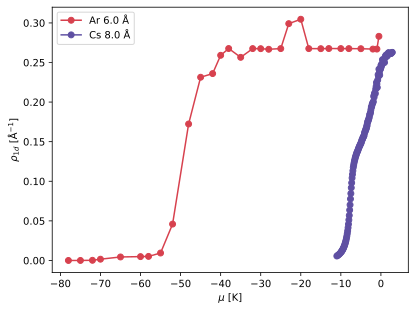

In [9]:
el,cR = 'Ar',6.0
plt.plot(μval[lab(el,cR)],ρ1d[lab(el,cR)], '-o', label=lab(el,cR), color=element_colors[el])
el,cR = 'Cs',8.0
plt.plot(μval[lab(el,cR)],ρ1d[lab(el,cR)], '-o', label=lab(el,cR), color=element_colors[el])
plt.legend()
plt.xlabel(r'$\mu$ [K]')    
plt.ylabel(r'$\rho_{1d}$ [Å$^{-1}$]')

## Now let's plot on a normalized scale

We shift such that the $x$-axis is constrained to be between $(0,1)$

\begin{equation}

\bar{\mu} = \frac{1}{{\mu_{max} - \mu_{min}}} (\mu - \mu_{\rm min})
\end{equation}

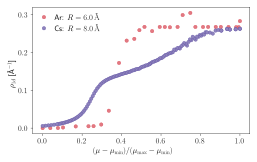

In [20]:
def y(μ,μmin,μmax):
    return (μ - μmin) / (μmax - μmin)

with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]), constrained_layout=True)
    trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)

    el,cR = 'Ar',6.0
    _y = y(μval[lab(el,cR)],μmin_max[el,cR][0],μmin_max[el,cR][1])
    ax.plot(_y,ρ1d[lab(el,cR)], 'o', label=f'{el}: $R = {cR:.1f}\,$'+r'${\rm \AA}$', mec=element_colors[el],
            mfc=colortools.get_alpha_hex(element_colors[el], 0.7),markersize=3.5, linewidth=0.5)

    el,cR = 'Cs',8.0
    _y = y(μval[lab(el,cR)],μmin_max[el,cR][0],μmin_max[el,cR][1])
    ax.plot(_y,ρ1d[lab(el,cR)], 'o', label=f'{el}: $R = {cR:.1f}\,$'+r'${\rm \AA}$', mec=element_colors[el],
            mfc=colortools.get_alpha_hex(element_colors[el], 0.7),markersize=3.5, linewidth=0.5)
    ax.legend()
    ax.set_xlabel(r'$(\mu - \mu_{\rm min})/(\mu_{\rm max}-\mu_{\rm min})$')    
    ax.set_ylabel(r'$\rho_{1d}$ [Å$^{-1}$]')

    plt.savefig('../figures/rho1d_vs_mu.pdf')

### Investigate the min/max pressures for Ar and Cs

In [11]:
for el in element:
    for cR in R:
        Pmin,Pmax = helium.pressure(μmin_max[el,cR][0],2.0), helium.pressure(μmin_max[el,cR][1],2.0)
        print(f'Pmin, Pmax for {lab(el,cR)}: {helium.convert_P(Pmin,"Pa","atm")} atm, {helium.convert_P(Pmax,"Pa","atm")} atm')
#helium.convert_P(helium.pressure(0.5,2.0),'Pa','atm')

Pmin, Pmax for Ar 6.0 Å: 1.3395863234925305e-17 atm, 1.8375023009713787 atm
Pmin, Pmax for Ar 8.0 Å: 4.045200183779792e-19 atm, 1.8375023009713787 atm
Pmin, Pmax for Cs 6.0 Å: 0.007885892693142157 atm, 30.029882298362846 atm
Pmin, Pmax for Cs 8.0 Å: 0.004766349446044454 atm, 30.029882298362846 atm


### Compute the effective 1D compressibility via a numerical derivative

In [35]:
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

def get_dn_dmu(μ,n,smooth='none'):
    if smooth=='none':
        n_smooth = n
    elif smooth=='gaussian':
        n_smooth = gaussian_filter1d(n, sigma=1)  # larger sigma = smoother
    elif smooth=='spline':
        spl = UnivariateSpline(μ, n, k=2, s=len(μ))  # increase/decrease s to smooth more/less
        n_smooth = spl(μ)
    elif smooth=='savgol':
        n_smooth = savgol_filter(n, window_length=7, polyorder=3)
         
    dn = np.gradient(n_smooth,μ)
    dn = np.abs(dn)
    dn[dn<0] = 0.0
    return dn


/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1253: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1269: RuntimeWarning: invalid value encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(

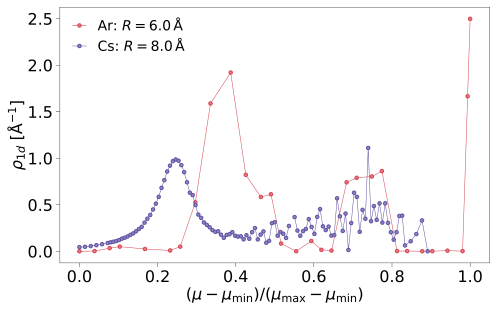

In [36]:
def plot_1d_compressibility(ax):
    
    for el,cR in [ ('Ar',6.0), ('Cs',8.0)]:
        _y = y(μ_sorted[lab(el,cR)],μmin_max[el,cR][0],μmin_max[el,cR][1])
        
        dn = get_dn_dmu(_y,ρ1d[lab(el,cR)][sort_idx[lab(el,cR)]],smooth='none')
        ax.plot(_y,dn, marker='o', label=f'{el}: $R = {cR:.1f}\,$'+r'${\rm \AA}$', mec=element_colors[el],
                mfc=colortools.get_alpha_hex(element_colors[el], 0.7),markersize=3.5, lw=0.5, color=element_colors[el])
    ax.legend()
    ax.set_xlabel(r'$(\mu - \mu_{\rm min})/(\mu_{\rm max}-\mu_{\rm min})$')    
    ax.set_ylabel(r'$\rho_{1d}$ [Å$^{-1}$]')


with plt.style.context('../include/notebook.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]), constrained_layout=True)

    plot_1d_compressibility(ax)